# Trees in Each Park

This notebook will help you discover using data which park in Strathcona County has the most trees.

Set up is done below, starting with downloading data sets directly from the Strathcona open data site. There are also some minor transformations which complicate things a little further. 

In [158]:
import geopandas as gpd
import pandas as pd 
import ast
import shapely
from shapely.wkt import loads
from shapely.geometry import Polygon, Point, MultiPolygon
import matplotlib.pyplot as plt

trees = pd.read_csv('https://data.strathcona.ca/api/views/v78i-7ntw/rows.csv?accessType=DOWNLOAD', converters={"Location": ast.literal_eval})
trees[['y_coord', 'x_coord']] =  pd.DataFrame(trees['Location'].tolist(), index=trees.index)
shape = pd.read_csv('https://data.strathcona.ca/api/views/m5yx-gw6e/rows.csv?accessType=DOWNLOAD')


In [151]:

small_shape = gpd.GeoDataFrame(shape[['Park_Name', 'the_geom']])
small_shape['the_geom'] = small_shape['the_geom'].apply(loads).copy()
#shape['geometry'] = shape['the_geom'].apply(loads)
trees = gpd.GeoDataFrame(trees, geometry=gpd.points_from_xy(trees.x_coord, trees.y_coord))
ss = pd.DataFrame(small_shape)
ss.rename(columns={'the_geom':'geometry'}, inplace=True)

# Maps
Makes sense to plot the data for the students - even if they don't do anything i think this adds another level to it. I do note that plotting the trees will be... well i wouldn't recommend it in terms of clobbering RAC. But even with the shape files it's interesting to see how spread out the parks are, and also all the green space that is decidedly _not_ a park 

In [183]:
# Slap them parks on folium to see where them parks are 
import folium
maploc = folium.Map(location=[53.5701,-113.0741],zoom_start=11)
frame = gpd.GeoDataFrame(ss, geometry='geometry',crs={'init': 'epsg:4326'})
tools = folium.features.GeoJsonTooltip(fields=['Park_Name'], aliases = ["Park name: "])
folium.features.GeoJson(frame, tooltip = tools).add_to(maploc)

maploc

## Recommendation 

Seeing as it's pretty hairy to get to this point in terms of the transformations required, I think we should start with the data set spit out here. I also note that only about half the trees are in parks (and that's okay - good potential question)

In [153]:
from geopandas.tools import sjoin
# this is doing a join that checks which park a tree lands in between both the frames
trees_parks = sjoin(trees, gpd.GeoDataFrame(ss), how='left')
trees_parks.head()

,TreeSiteID,Name,Location,y_coord,x_coord,geometry,index_right,Park_Name
0,22439,Poplar spp,"(53.5227206433883, -113.324197520184)",53.522721,-113.324198,POINT (-113.32420 53.52272),28.0,Kinsmen/Westboro Park
1,19106,Spruce spp,"(53.5580354097226, -113.311519305079)",53.558035,-113.311519,POINT (-113.31152 53.55804),90.0,Millennium Place Athletic Park
2,30088,Colorado Spruce,"(53.5279674658552, -113.311713218285)",53.527967,-113.311713,POINT (-113.31171 53.52797),21.0,Broadmoor Public Golf Course
3,33800,Schubert Chokecherry,"(53.515577567706, -113.320470094948)",53.515578,-113.320470,POINT (-113.32047 53.51558),NaN,NaN
4,13305,Green Ash,"(53.5194628194035, -113.324964991257)",53.519463,-113.324965,POINT (-113.32496 53.51946),NaN,NaN


# Plotting Trees in Each Park

This is a little tricky to get to - This might not be something we get the students to do 

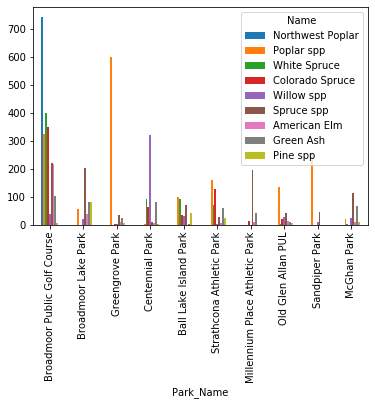

In [155]:
group = trees_parks.groupby(['Park_Name', 'Name']).count().sort_values(by='y_coord', ascending=False)
x = trees_parks.groupby(['Park_Name']).count().sort_values(by='y_coord', ascending=False)
df = group['geometry'].unstack().reset_index().set_index("Park_Name")
df = df[df.columns[df.sum()>500]]
df.loc[x.index][:10].plot(kind='bar')

# Park with highest density of trees
This one actually isn't too hard to do - the hard part is you need to change the projection from lat/long to cartesian so area returns square meters instead of angular area. 

In [156]:
#trees_parks.crs = {'init': 'epsg:3857'}
#trees_parks['area'] = trees_parks['geometry'].area
a = gpd.GeoDataFrame(ss, crs={'init': 'epsg:4326'})

a['area'] = a.to_crs({'init': 'epsg:3857'})['geometry'].area 

trees_w_area =sjoin(trees, gpd.GeoDataFrame(a), how='left')
trees_w_area.head()

,TreeSiteID,Name,Location,y_coord,x_coord,geometry,index_right,Park_Name,area
0,22439,Poplar spp,"(53.5227206433883, -113.324197520184)",53.522721,-113.324198,POINT (-113.32420 53.52272),28.0,Kinsmen/Westboro Park,1.001669e+05
1,19106,Spruce spp,"(53.5580354097226, -113.311519305079)",53.558035,-113.311519,POINT (-113.31152 53.55804),90.0,Millennium Place Athletic Park,4.803654e+05
2,30088,Colorado Spruce,"(53.5279674658552, -113.311713218285)",53.527967,-113.311713,POINT (-113.31171 53.52797),21.0,Broadmoor Public Golf Course,1.847492e+06
3,33800,Schubert Chokecherry,"(53.515577567706, -113.320470094948)",53.515578,-113.320470,POINT (-113.32047 53.51558),NaN,NaN,NaN
4,13305,Green Ash,"(53.5194628194035, -113.324964991257)",53.519463,-113.324965,POINT (-113.32496 53.51946),NaN,NaN,NaN


# Area Plot

I think this should be reasonable to get the students to do provided we give them area and tell them the units, we will need to find a smoother merge (certainly a join will probably do - I just haven't done it here) 

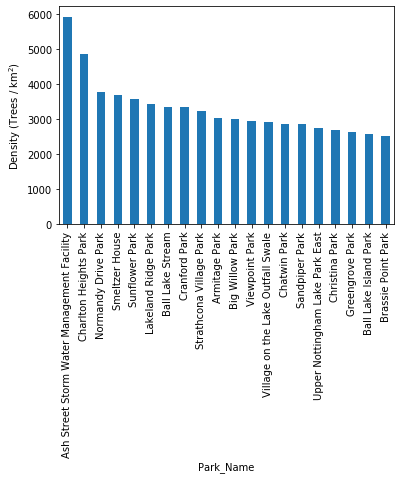

In [160]:
x = trees_parks.groupby("Park_Name").count().reset_index()[["Park_Name", "Location"]]
# Probably a easier join 
x2 = pd.merge(trees_w_area[['Park_Name', 'area']], x, on = "Park_Name").drop_duplicates(subset="Park_Name")
x2['density'] = x2['Location'] / (x2['area']/1e6)
x2=x2.set_index("Park_Name")
ax = x2.sort_values('density', ascending=False)['density'][:20].plot(kind='bar')
ax.set_ylabel("Density (Trees / km$^2$)")
plt.show()